# Projeto de geometria de torre 69 kV
Torre circuito simples triangular.

Resultados esperados conforme projeto:

Ângulo de balanço (°)

| Solicitação |     |
|-------------|-----|
| Tensão máxima operativa | 63 |

Distâncias de isolamento (m)

| Solicitação | Fase-terra | Fase-fase |
|-------------|----------------|-----------|
| Tensão máxima operativa | 0.100 | x |
| Surto de manobra | 0.500 | 0.600 |

In [1]:
import normaslt as lt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from tabulate import tabulate
from normaslt import nbr1985, nbr5422
from math import ceil, degrees, radians, sin, cos, sqrt, exp
from IPython.display import HTML, display
from normaslt.geral import dbCabo
from normaslt.draw import find_line_start, minDistancePts, plot_dimension, plot_balanco, plot_cadeia, plot_distance_radius, plot_line_pt, xmax
from normaslt.types import amp, obs

In [2]:
# Dados de projeto
vNom = 69.
vMax = 72.5
ftmo = 1.05 # 72.5 kV
cond = dbCabo.CAA_GROSBEAK
vVento = 350 # vão médio (vento)
vpvm = 0.8 # Relação vão de peso/ vão de vento
vPeso = vVento*vpvm # vão de peso (gravante)
eds = 0.2
# Variáveis climatológicas e ambientais
tmed = 18. # Temperatura media (NBR 5422:1985, Anexo A, fig. 23)
tmedmin = 13. # Média das temperaturas mínimas, ou coincidente (NBR 5422:1985, Anexo A, fig. 27)
dra = 0.91
alt = 500 # Altitude, m (variável entre 15 a 1000 m)
FCAfi = 0.94
FCAim = 0.91
# Estrutura
ht = 20.
d = 2.
s = 0.8
# sobretensões - ver se usa valores tipicos da norma
muft50 = 2.1
muft98 = 2.5
muff50 = 2.0
muff98 = 2.3
sigmaft = 0.1
sigmaff = 0.2
alpha = 0.5
# Fatores de gaps frente lenta
# "condutor-estrutura lateral"
kgfn = 1.45 + 0.35*(exp(-8. * s/d)-0.2) # Pegando cálculo na ref. Cigre original
kgff = 1.62 # "condutor-condutor", alpha 0.5
# Ventos de projeto - distribuição Gumbel
gumbelAlfa = 0.25 # Parâmetro alfa de Gumbel, (m/s)⁻¹
gumbelBeta = 16 # Parâmetro beta de Gumbel, m/s
# Temperatura de operação (°C)
ttipn = 50 # 15% risco térmico
ttips = 60 # 5% risco térmico
tlims = 70 # 1% risco térmico
# Cadeia de isoladores
dIsol = 0.280
passoIsol = 0.170
distEscoam = 0.380
Decr = 25 # distância de escoamento (mm/kVff) - poluição muito leve.
lFerragem = 0.28 # Comprimento adicional por ferragem (superior e inferior)

## Elementos em comum

### Cadeia de isoladores
(não referenciado na NBR 5422:1985 mas de prática comum)
$$
n = \left\lceil \frac{V_{\max} \, D_{ecr}}{D_{esc}} \right\rceil + n_{ex}
$$
Sendo $V_{\max}$ a tensão operativa máxima de linha, $D_{esc}$ a relação de distância de escoamento, $D_{esc}$ a distância de escoamento por isolador, $n_{ex}$ a previsão de número de isoladores extras e $\lceil x \rceil$ a operação de arredondar para cima.

### Flecha
Pode-se usar aproximação da parábola:
$$
f = \frac{p \, A^2}{8 \, T}
$$
Sendo $p$ o peso linear do cabo (N/m), $A$ o commprimento do vão (m) e $T$ a tração aplicada (N). A partir da flecha de referência (EDS), calcula-se as outras condições de temperatura pelas equações de estado.

In [3]:
# Cadeia de isoladores
nc = ceil(vMax * Decr / (distEscoam * 1e3)) + 1
lcadeia = nc * passoIsol + lFerragem
print(f"Cadeia de {nc} isoladores, comprimento {lcadeia:.2f} m.")
# A partir do número de isoladores, obtem-se os dados de suportabilidade de frente rápida (catálogo Hubbell, p. 124)
cfop = 610
cfon = 630

# Flechas
f18 = lt.geral.flecha2(cond.p, vVento, cond.T * eds) # Na ref. indica 21 m, não ficou claro qual foi a condição, aparentemente em torno de 50°C. 
f50, _ = lt.geral.equacaoEstado(cond.p, vVento, cond.T * eds, cond.S, cond.E, cond.alfa1, tmed, ttipn)
f60, _ = lt.geral.equacaoEstado(cond.p, vVento, cond.T * eds, cond.S, cond.E, cond.alfa1, tmed, ttips)
f70, _ = lt.geral.equacaoEstado(cond.p, vVento, cond.T * eds, cond.S, cond.E, cond.alfa1, tmed, tlims)
print(f"Flechas: EDS {f18:.2f} m, 50ºC: {f50:.2f} m, 60ºC: {f60:.2f} m, 70ºC: {f70:.2f} m.")

Cadeia de 6 isoladores, comprimento 1.30 m.
Flechas: EDS 8.80 m, 50ºC: 10.04 m, 60ºC: 10.41 m, 70ºC: 10.77 m.


## Parte 0 - projeto de referência

Plotação da cabeça de torre conforme referência.

Cálculo dos ângulos de balanço com velocidade de vento com tempo de retorno de 30 anos (39.4 m/s) e vento reduzido em 60% (23.6 m/s).

Não foi considerada deflexão na torre.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


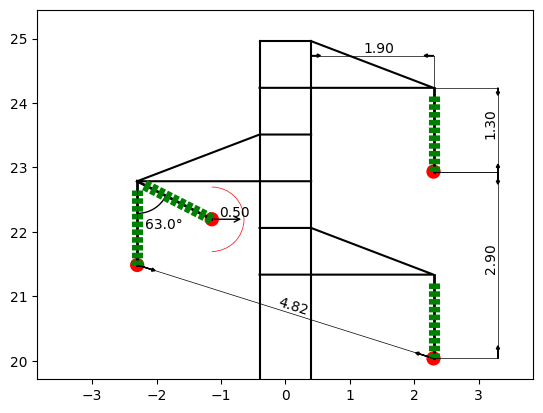

In [4]:
# Estrutura
espLt = 0.8
lMisula = 1.9
hMod = 0.725
# Posição das fases
xr = espLt/2 + lMisula
x1 = xr
x2 = -xr
x3 = xr
# Alturas relativas à fase mais baixa
y1 = 0.
y2 = 1.45
y3 = 2.9
h = 10. # clearance (m)
# Ângulos de balanço
ang1 = 63
dist1 = 0.5
hbase = h + f50 + lcadeia
y1t = y1+hbase
y2t = y2+hbase
y3t = y3+hbase
ht = y3t+hMod

plt.figure()
plt.plot([-espLt/2, -espLt/2], [0, ht],'k-')
plt.plot([espLt/2, espLt/2], [0, ht],'k-')
plt.plot([-espLt/2, espLt/2], [ht, ht],'k-')
plt.plot([-espLt/2, x1, espLt/2, -espLt/2], [y1t, y1t, y1t+hMod, y1t+hMod],'k-')
plt.plot([espLt/2, x2, -espLt/2, espLt/2], [y2t, y2t, y2t+hMod, y2t+hMod],'k-')
plt.plot([-espLt/2, x3, espLt/2], [y3t, y3t, ht],'k-')
plt.plot([-3.5, 3.5], [0, 0],'k-', linewidth=0.5)
ptsF1 = plot_cadeia(plt, (x1,y1t), l=lcadeia, ang=0, wcad=8)
ptsF2 = plot_cadeia(plt, (x2,y2t), l=lcadeia, ang=0, wcad=8)
ptsF3 = plot_cadeia(plt, (x3,y3t), l=lcadeia, ang=0, wcad=8)
plot_dimension(plt, (espLt/2, y3t), (x3,y3t), offset=0.5)
plot_dimension(plt, ptsF3[0], (x3,y3t), offset=-1)
plot_dimension(plt, ptsF2[0], ptsF1[0], offset=0)
plot_dimension(plt, ptsF1[0], ptsF3[0], offset=-1)
ptsF2 = plot_cadeia(plt, (x2,y2t), l=lcadeia, ang=ang1, wcad=8)
plot_distance_radius(plt, ptsF2[0], radius=dist1)
plt.axis('equal')
plt.gca().set_ylim(20, ht+0.2)
plt.show()

## Parte 1 - versão 1985

Aplicação da norma "pura".

### Altura condutor-solo (seção 10.3)

#### Método convencional:
$$
D = a + 0.01 \left( \frac{D_U}{\sqrt 3} - 50 \right)
$$

Sendo $D_U =$ 1 m/kV referente a tensão máxima fase-fase da linha, $a =$ 6.0 m para locais acessíveis a pedestres.

#### Método alternativo:
$$
D = a_1 + b \, c \left[ \left(  \frac{\sqrt{2 \, D_U}}{\sqrt 3} P_U \, + V_L \right) \frac{a_2}{500 \, k}\right]^{1.667}
$$
Sendo $P_U$ o valor de sobretensão de manobra (f-t, crista) com probabilidade de 98% de não ser excedido, $a_2 =$ 1.15, $b =$ 1.03, $V_L =$ 0, e $P_U$ o valor de sobretensão de manobra a 98%. Para locais acessíveis a pedestres, $a_1 =$ 2.8, $c =$ 1.2, $k =$ 1.15.

In [5]:
a = 6.
Du = vMax
d1 = a + 0.01 * (Du/sqrt(3) - 50.)
a1 = 2.8
a2 = 1.15
b = 1.03
c = 1.2
k = 1.
vl = 0.
pu = muft98 
d2 = a1+b*c*((sqrt(2*Du/3) * pu)*a2/(500*k))**1.667
print(f"Distancias condutor-solo, acesso a pedestres: dConv = {d1:.2f} m, dAlt = {d2:.2f} m.")
d = max(d1, d2)
hTorre = d + f50
hCad = hTorre + lcadeia
print(f"Altura do condutor inferior na torre: {hTorre:.2f} m.")
print(f"Altura da fixação da cadeia inferior: {hCad:.2f} m.")

Distancias condutor-solo, acesso a pedestres: dConv = 5.92 m, dAlt = 2.81 m.
Altura do condutor inferior na torre: 15.95 m.
Altura da fixação da cadeia inferior: 17.25 m.


In [6]:
# Distâncias de segurança em paralelismo e cruzamento - LD 34.5 kV
# Paralelismo (horizontal - seção 10.5, figura A.10)
# Balanço com período de retorno 10 anos
dH = 0.22 + 0.01 * Du
if dH < 1.5: dH = 1.5
 

### Ventos de projeto

Ambas as versões usam o tempo de integração de 30 s. Para a versão de 1985 aplica-se a função correspondente a Figura 1.

Para balanço de condutor, define-se:
* Período de retorno de 10 anos (seção 10.1.4.1), para distância mĩnima no suporte (10.2) e distância mínima entre condutores em suporte diferentes (10.5).
* Período de reorno de 50 anos para distâncias mínima para obstáculos em condições nominais (10.3) e emergência (10.4).

Correção pela altura média do condutor:
$$
K_{alt} = \left( \frac{z}{10} \right)^\alpha
$$
sendo $\alpha = 1/n =$ 0.16 para cat. B.

In [7]:
V10t10m = nbr1985.correcaoVentoPeriodoRetornoSecao4(gumbelAlfa, gumbelBeta, 10)
print(f"Vento de projeto, período de retorno 10 anos: {V10t10m:.2f} m/s.")
h = 17
V10t30s = nbr1985.fatCorrInt(30) * nbr1985.fatCorrAlt(h) * V10t10m
print(f"Vento de projeto, tempo de integração 30 s: {V10t30s:.2f} m/s.")
V50t10m = nbr1985.correcaoVentoPeriodoRetornoSecao4(gumbelAlfa, gumbelBeta, 50)
print(f"Vento de projeto, período de retorno 50 anos: {V50t10m:.2f} m/s.")
V50t30s = nbr1985.fatCorrInt(30) * nbr1985.fatCorrAlt(h) * V50t10m
print(f"Vento de projeto, tempo de integração 30 s, período de retorno 50 anos: {V50t30s:.2f} m/s.")

Vento de projeto, período de retorno 10 anos: 25.00 m/s.
Vento de projeto, tempo de integração 30 s: 33.04 m/s.
Vento de projeto, período de retorno 50 anos: 31.61 m/s.
Vento de projeto, tempo de integração 30 s, período de retorno 50 anos: 41.78 m/s.


### Ângulo de balanço

Parcela comum às duas versões:

$$
\beta = \tg^{-1} \left( K \frac{q_0 \, d \, L_m}{p \, L_p} \right)
$$

Sendo $V_p$ o vento de projeto para período de integração de 30 s.

Se considerar uma deflexão de linha $\theta$, deve-se adaptar a formulação:
$$
\beta = \tg^{-1} \left[ K \frac{q_0 \, d \, L_m + 2 \, T \sin(0.5 \, \theta)}{p \, L_p} \right]
$$

In [8]:
mu = nbr1985.massaAr(alt, tmed)
q010 = 0.5*mu*V10t30s**2
q050 = 0.5*mu*V50t30s**2
theta = 2

ang1 = degrees(nbr1985.anguloBalanco(V10t30s, q010, cond.d, cond.p, Lm=vVento, Lp=vPeso))
ang1d = degrees(nbr1985.anguloBalancoDeflexao(V10t30s, q010, cond.d, cond.p, theta, cond.T * eds, vVento, vPeso))
print(f"Pressão de vento 10 anos: {q010:.1f} N/m²")
print(f"Ângulos de balanço 10 anos: em alinhamento {ang1:.1f}°, com deflexão {ang1d:.1f}°")
ang2 = degrees(nbr1985.anguloBalanco(V50t30s, q050, cond.d, cond.p, Lm=vVento, Lp=vPeso))
print(f"Pressão de vento 50 anos: {q050:.1f} N/m²")
print(f"Ângulos de balanço 50 anos: {ang2:.1f}°")


Pressão de vento 10 anos: 622.3 N/m²
Ângulos de balanço 10 anos: em alinhamento 25.9°, com deflexão 29.0°
Pressão de vento 50 anos: 994.5 N/m²
Ângulos de balanço 50 anos: 36.7°


### Distâncias de segurança (seção 10)

* Distâncias mínimas no suporte: período de retorno de 10 anos.
* Distâncias mínimas entre condutores em suportes diferentes: período de retorno de 10 anos.
* Distâncias mínima condutor-solo ou obstáculos: período de retorno de 50 anos.

Método convencional:
* Distância vertical entre fases, $U >$ 50 kV: não especificado.
* Distâncias fase-terra:
  * Para-raios: $D = 0.22 + 0.01 D_U$
  * Suporte: $D = 0.03 + 0.005 D_U$
  * Estais: $D = 0.09 + 0.006 D_U$

In [9]:
dftfl = 0.03 + 0.005 * vMax 
print(f"Distâncias fase-terra: {dftfl:.2f} m.")

Distâncias fase-terra: 0.39 m.


### Geometria final

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


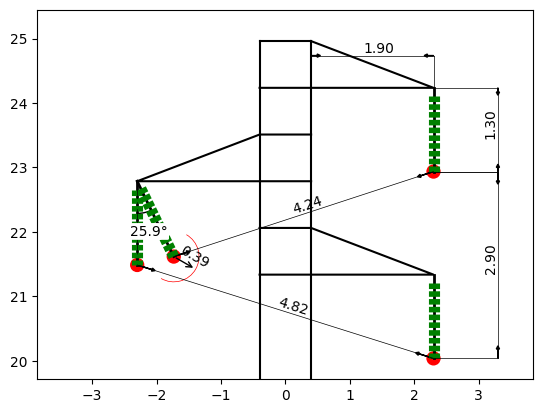

In [10]:
# Posição das fases
xr = espLt/2 + lMisula
x1 = xr
x2 = -xr
x3 = xr
# Alturas relativas à fase mais baixa
y1 = 0.
y2 = 1.45
y3 = 2.9
h = 10. # clearance (m)
# Ângulos de balanço
dist1 = dftfl
hbase = h + f50 + lcadeia
y1t = y1+hbase
y2t = y2+hbase
y3t = y3+hbase
ht = y3t+hMod

plt.figure()
plt.plot([-espLt/2, -espLt/2], [0, ht],'k-')
plt.plot([espLt/2, espLt/2], [0, ht],'k-')
plt.plot([-espLt/2, espLt/2], [ht, ht],'k-')
plt.plot([-espLt/2, x1, espLt/2, -espLt/2], [y1t, y1t, y1t+hMod, y1t+hMod],'k-')
plt.plot([espLt/2, x2, -espLt/2, espLt/2], [y2t, y2t, y2t+hMod, y2t+hMod],'k-')
plt.plot([-espLt/2, x3, espLt/2], [y3t, y3t, ht],'k-')
plt.plot([-3.5, 3.5], [0, 0],'k-', linewidth=0.5)
ptsF1 = plot_cadeia(plt, (x1,y1t), l=lcadeia, ang=0, wcad=8)
ptsF2 = plot_cadeia(plt, (x2,y2t), l=lcadeia, ang=0, wcad=8)
ptsF3 = plot_cadeia(plt, (x3,y3t), l=lcadeia, ang=0, wcad=8)
plot_dimension(plt, (espLt/2, y3t), (x3,y3t), offset=0.5)
plot_dimension(plt, ptsF3[0], (x3,y3t), offset=-1)
plot_dimension(plt, ptsF2[0], ptsF1[0], offset=0)
plot_dimension(plt, ptsF1[0], ptsF3[0], offset=-1)
ptsF2 = plot_cadeia(plt, (x2,y2t), l=lcadeia, ang=ang1, wcad=8)
plot_dimension(plt, ptsF2[0], ptsF3[0], offset=0)
plot_distance_radius(plt, ptsF2[0], radius=dist1, angle=-30)
plt.axis('equal')
plt.gca().set_ylim(20, ht+0.2)
plt.show()

## Parte 2 - versão 2024

### Altura condutor-solo (seção 7.2)

A título de exemplo, considerando aqui somente a altura típica nominal (a rigor deve-se observar as quatro condições):
$$
D_{Vtip,n} = P_{bV} + P_{stip} + P_{etip,n}
$$

Para a mesma premissa de acesso somente a pedestres: $k_g =$ 1.47, $P_{bV} =$ 4.20 m. A parcela elétrica $P_{etip,n}$ é calculada para a sobretensão de frente lenta (seção 9.4.1):
$$
P_e = 2.174 \left[ \exp \left( \frac{K_{CS} \, \sqrt 2 \, U_S \, F_{Sfl}}{1080 \, \sqrt 3 \, k_{afl} \, k_{zfl} \, k_g}\right) - 1\right]
$$
Usando $k_{zfl} = 1 - 1.3 \times 0.06$, recomendado pela norma, $K_{CS} = $ 1.35 (seção 7.2.5.1) e estimando $k_{afl}$ para uma distância de 10 m.

In [11]:
umidAbs = nbr5422.umidAbs(dra, tmed)
kafl = nbr5422.fatAtmFrenteLenta(dra, umidAbs, 10.) 
h, Petip, Pelim = nbr5422.distSegurancaVert(obs.PEDESTRE, amp.TIPICA_NOMINAL, 0.0, vNom, muft98, kafl) 
print(f"Altura mínima condutor-solo: {h:.2f} m. Parcelas elétricas: Petip = {Petip:.2f} m, Pelim = {Pelim:.2f} m")
hTorre = h + f50
print(f"Altura do condutor na torre: {hTorre:.2f} m.")

Altura mínima condutor-solo: 6.61 m. Parcelas elétricas: Petip = 0.92 m, Pelim = 0.91 m
Altura do condutor na torre: 16.65 m.


### Ventos de projeto

Para a versão 2024 aplica-se o fator de turbulência $K_{tur}$, considerado para a região Sul igual a 1.08, e o fator de integração $K_{int} =$ 1.22.
$$
V_{P30s} = K_{int} \, K_{tur} \, V_R
$$
Considerando a mesma velocidade base, obtida pelos parâmetros de Gumbel.

In [12]:
h = 10.0 # Altura média do cabo condutor
V10t10m = nbr1985.correcaoVentoPeriodoRetornoSecao4(gumbelAlfa, gumbelBeta, 10)
Vp30s = nbr5422.fatCorrInt30s() * nbr5422.fatCorrAlt(h) * nbr5422.fatTurb(lt.types.regiao.S) * V10t10m
print(f"Vento de projeto, tempo de integração 30 s, período de retorno 10 anos: {Vp30s:.2f} m/s.")
V2t10m = nbr1985.correcaoVentoPeriodoRetornoSecao4(gumbelAlfa, gumbelBeta, 2)
VpRed = nbr5422.fatCorrInt30s() * nbr5422.fatCorrAlt(h) * nbr5422.fatTurb(lt.types.regiao.S) * V2t10m
print(f"Vento de projeto, tempo de integração 30 s, período de retorno 2 anos: {VpRed:.2f} m/s.")

Vento de projeto, tempo de integração 30 s, período de retorno 10 anos: 32.94 m/s.
Vento de projeto, tempo de integração 30 s, período de retorno 2 anos: 23.01 m/s.


### Ângulos de balanço

Para a versão 2024 aplica-se o desvio padrão para o ângulo máximo:
$$
\begin{align*}
\sigma_\beta & = 2.25 \left[1 - \exp \left( -\frac{V_p^2}{230}\right) \right] \\
\beta_{\max} & = \beta + 2 \sigma_\beta
\end{align*}
$$

Ângulos de balanço considerados (seção 9.6.2)

* Frequência fundamental: período de retorno mínimo de 10 anos.
* Impulso de frente lenta: período de retorno mínimo de 2 anos.
* Impulso de frente rápida: não considera ação do vento.

In [13]:
mu = nbr5422.massaAr(alt, tmed)
q010 = 0.5*mu*Vp30s**2
print(f"Pressão de vento: {q010:.2f} N/m²")
ang1 = nbr5422.anguloBalanco(Vp30s, q010, cond.d, cond.p, VpVv=vpvm)
ang1min, ang1max = nbr5422.anguloBalancoAssincrono(Vp30s, ang1)
ang1 = degrees(ang1)
ang1min = degrees(ang1min)
ang1max = degrees(ang1max)
print(f"Ângulo de balanço médio {ang1:.1f}°, mínimo {ang1min:.1f}º, máximo {ang1max:.1f}º.")
q02 = 0.5*mu*VpRed**2
print(f"Pressão de vento reduzida: {q02:.2f} N/m²")
ang2 = nbr5422.anguloBalanco(VpRed, q02, cond.d, cond.p, VpVv=vpvm)
ang2min, ang2max = nbr5422.anguloBalancoAssincrono(VpRed, ang2) 
ang2 = degrees(ang2)
ang2min = degrees(ang2min)
ang2max = degrees(ang2max)
print(f"Ângulo de balanço reduzido, médio {ang2:.1f}°, mínimo {ang2min:.1f}º, máximo {ang2max:.1f}º.")

Pressão de vento: 619.51 N/m²
Ângulo de balanço médio 25.8°, mínimo 21.3º, máximo 30.3º.
Pressão de vento reduzida: 302.35 N/m²
Ângulo de balanço reduzido, médio 16.0°, mínimo 12.0º, máximo 20.1º.


### Geometria da torre

#### Coordenação de isolamento (seção 9)

In [14]:
# Isolamento na tensão máxima frequência industrial
kg = 1.35 * kgfn - 0.35 * kgfn**2
dftfi = nbr5422.espacFTFreqFund(Us=vNom, Ftmo=ftmo, kaff=FCAfi, kgff=kg, zff=0.)
kg = 1.35 * kgff - 0.35 * kgff**2
dfffi = nbr5422.espacFFFreqFund(Us=vNom, Ftmo=ftmo, kaff=FCAfi, kgff=kg, zff=0.)
print(f"Distâncias para isolamento a frequência industrial: fase-terra {dftfi:.2f} m, fase-fase {dfffi:.2f} m.")

Distâncias para isolamento a frequência industrial: fase-terra 0.14 m, fase-fase 0.21 m.


In [15]:
# Isolamento a sobretensões de frente lenta
# Energização
kcs = 1.178 # Figura C.1, 50 gaps, risco 1e-2, Cvsfl 0.05, Cvfl 0.06
fsfl = muft98
dftfl = nbr5422.espacFTFrenteLenta(Us=vNom, Kcs=kcs, Fsfl=fsfl, kafl=FCAim, kg=kgfn)
kcs = 1.245 # Figura C.1, 1110 gaps, risco 1e-2, Cvsfl 0.05, Cvfl 0.06
fsfl = muff98
dfffl = nbr5422.espacFFFrenteLenta(Us=vNom, Kcs=kcs, Fsfl=fsfl, kafl=FCAim, kg=kgff, alpha=alpha)
print(f"Distâncias para isolamento sobretensões frente lenta: fase-terra {dftfl:.2f} m, fase-fase {dfffl:.2f} m.")

Distâncias para isolamento sobretensões frente lenta: fase-terra 0.92 m, fase-fase 0.93 m.


In [16]:
# Isolamento a sobretensões de frente rápida
bilp = cfop * (1 - 1.28*0.03)
biln = cfon * (1 - 1.28*0.03)
dftfrp = nbr5422.espacFTFrenteRapidaPos(bilp, kafr=dra, kg=kgfn) 
dftfrn = nbr5422.espacFTFrenteRapidaNeg(biln, kafr=dra, kg=kgfn) 
dfffr = nbr5422.espacFFFrenteRapida(bilp, kafr=dra, kg=kgff)
print(f"Distâncias para isolamento sobretensões frente lenta: fase-terra positiva {dftfrp:.2f} m, negativa {dftfrn:.2f} m, fase-fase {dfffr:.2f} m.")

Distâncias para isolamento sobretensões frente lenta: fase-terra positiva 1.15 m, negativa 1.23 m, fase-fase 1.31 m.


#### Esboço da cabeça da torre
Mesmo procedimento da versão 1985.

Considerar o balanço assícnrono na torre ($\beta_{min}$ e $\beta_{max}$) para determinação das distâncias entre fases (seção 9.6.3).

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


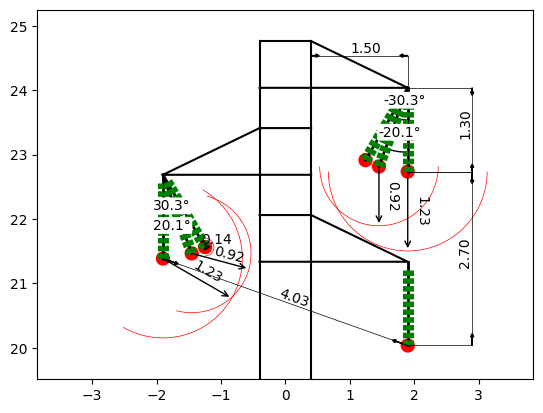

In [17]:
# Posição das fases
lMisula = 1.5
xr = espLt/2 + lMisula
x1 = xr
x2 = -xr
x3 = xr
# Alturas relativas à fase mais baixa
hff = 2.7
y1 = 0.
y2 = hff/2
y3 = hff
h = 10. # clearance (m)
# Ângulos de balanço
dist1 = dftfi
dist2 = dftfl
dist3 = max(dftfrp, dftfrn)
hbase = h + f50 + lcadeia
y1t = y1+hbase
y2t = y2+hbase
y3t = y3+hbase
ht = y3t+hMod

plt.figure()
plt.plot([-espLt/2, -espLt/2], [0, ht],'k-')
plt.plot([espLt/2, espLt/2], [0, ht],'k-')
plt.plot([-espLt/2, espLt/2], [ht, ht],'k-')
plt.plot([-espLt/2, x1, espLt/2, -espLt/2], [y1t, y1t, y1t+hMod, y1t+hMod],'k-')
plt.plot([espLt/2, x2, -espLt/2, espLt/2], [y2t, y2t, y2t+hMod, y2t+hMod],'k-')
plt.plot([-espLt/2, x3, espLt/2], [y3t, y3t, ht],'k-')
plt.plot([-3.5, 3.5], [0, 0],'k-', linewidth=0.5)
ptsF1 = plot_cadeia(plt, (x1,y1t), l=lcadeia, ang=0, wcad=8)
ptsF2 = plot_cadeia(plt, (x2,y2t), l=lcadeia, ang=0, wcad=8)
plot_distance_radius(plt, ptsF2[0], radius=dist3, angle=-30)
ptsF3 = plot_cadeia(plt, (x3,y3t), l=lcadeia, ang=0, wcad=8)
plot_distance_radius(plt, ptsF3[0], radius=dist3, angle=-90)
plot_dimension(plt, (espLt/2, y3t), (x3,y3t), offset=0.5)
plot_dimension(plt, ptsF3[0], (x3,y3t), offset=-1)
plot_dimension(plt, ptsF2[0], ptsF1[0], offset=0)
plot_dimension(plt, ptsF1[0], ptsF3[0], offset=-1)
ptsF2fi = plot_cadeia(plt, (x2,y2t), l=lcadeia, ang=ang1max, wcad=8, angle_offset=0.2)
ptsF2fl = plot_cadeia(plt, (x2,y2t), l=lcadeia, ang=ang2max, wcad=8, angle_offset=0.5)
plot_distance_radius(plt, ptsF2fi[0], radius=dist1)
plot_distance_radius(plt, ptsF2fl[0], radius=dist2, angle=-15)
ptsF3fi = plot_cadeia(plt, (x3,y3t), l=lcadeia, ang=-ang1max, wcad=8, angle_offset=0.5)
ptsF3fl = plot_cadeia(plt, (x3,y3t), l=lcadeia, ang=-ang2max, wcad=8, angle_offset=1)
plot_distance_radius(plt, ptsF3fl[0], radius=dist2, angle=-90)
plt.axis('equal')
plt.gca().set_ylim(20, ht)
plt.show()